In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices, dmatrix
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
import numpy as np
#from keras.utils import to_categorical
#from keras.models import Sequential
#from keras.layers import Dense, Activation
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle

seed = 5
np.random.seed(seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [28]:
lc_2015 = pd.read_csv('lc_2015.csv', header=1, low_memory=False)
lc_2015_dec = pd.read_csv('lc_2015_dec.csv', header=1, low_memory=False)

In [29]:
# Load pickles

file = open('prob_A_model', 'rb')
rf_A = pickle.load(file)
file.close()

In [30]:
lc_2015['grade'].value_counts()

C    120567
B    117606
A     73336
D     62654
E     34948
F      9817
G      2167
Name: grade, dtype: int64

In [31]:
# Replicate Jeremy's column

from datetime import datetime

days_since_last_credit_pull_d = []
for i in lc_2015['last_credit_pull_d']:
    try:
        temp_date = datetime.strptime(i, '%b-%Y')
        days_since_last_credit_pull_d.append((datetime.today() - temp_date).days)
    except:
        days_since_last_credit_pull_d.append(0)
        
lc_2015['days_since_last_credit_pull_d'] = days_since_last_credit_pull_d

In [32]:
#lc_d_2015 = lc_2015[((lc_2015['loan_status']=='Fully Paid') | (lc_2015['loan_status']=='Charged Off'))].copy()

lc_d_2015 = lc_2015[((lc_2015['grade']=='D')
                   | (lc_2015['grade']=='E')
                   | (lc_2015['grade']=='F')
                   | (lc_2015['grade']=='G'))
                   & (lc_2015['term']==' 36 months')
                   & ((lc_2015['loan_status']=='Fully Paid') | (lc_2015['loan_status']=='Charged Off'))
                  ].copy()

lc_d_2015.reset_index(inplace=True)

In [33]:
lc_d_2015['loan_status'].value_counts()/np.sum(lc_d_2015['loan_status'].value_counts())

Fully Paid     0.717367
Charged Off    0.282633
Name: loan_status, dtype: float64

In [34]:
lc_d_2015['loan_status'].value_counts()

Fully Paid     31392
Charged Off    12368
Name: loan_status, dtype: int64

In [35]:
# Clean up the dataframe

# Make my outcome variable 0s and 1s
outcome_var = []
for i in lc_d_2015['loan_status']:
    if i == 'Charged Off':
        outcome_var.append(1)
    else:
        outcome_var.append(0)
lc_d_2015['outcome_var'] = outcome_var

# Find all the mths_since columns
mths_since_list = [i for i in lc_d_2015.columns if 'mths_since' in i]

# Bin the mths_since columns to make them valid inputs
for col in mths_since_list:
    if col != 'sec_app_mths_since_last_major_derog':
        category = list(pd.cut(lc_d_2015[col], bins=4, labels=['0', '1', '2', '3']))
        for i, val in enumerate(category):
            if type(val) != str:
                if np.isnan(val):
                    category[i] = '4'
    lc_d_2015[col + '_cat'] = category
    
# Replace nulls in columns with strings (i.e. if no job title, replace null with 'none')
ok_list = ['emp_title','emp_length']
for col in ok_list:
    new_list = []
    col_values = list(lc_d_2015[col])
    for i, val in enumerate(col_values):
        if type(val) != str:
            if np.isnan(val):
                new_list.append('none')
            else:
                new_list.append(val)
        else:
            new_list.append(val)
    new_col_name = col + '_2'
    lc_d_2015[new_col_name] = new_list

In [36]:
# Count the nulls for each column and store each count in a dictionary (keys = column name)
def count_null(df):
    null_dict = {}
    for i in df.columns:
        if i in null_dict:
            null_dict[i] += sum([1 for j in lc_d_2015[i].isna() if j])
        else:
            null_dict[i] = sum([1 for j in lc_d_2015[i].isna() if j])
    return null_dict

null_dict = count_null(lc_d_2015)

In [37]:
# Check df shape before dropping nulls
lc_d_2015.shape

(43760, 159)

In [38]:
# Drop nulls
for key, val in null_dict.items():
    if val >= 5000:
        lc_d_2015.drop(labels=key, axis=1, inplace=True)
        
null_dict2 = count_null(lc_d_2015)

lc_d_2015.dropna(inplace=True)
lc_d_2015.shape

(32155, 101)

In [39]:
lc_d_2015['loan_status'].value_counts()

Fully Paid     23119
Charged Off     9036
Name: loan_status, dtype: int64

In [40]:
#Include?        	LoanStatNew
#Keep for agg    	id
#Maybe           	last_pymnt_amnt
#Maybe           	last_pymnt_d
#Outcome         	loan_status
#Keep for agg    	member_id
#Maybe           	sub_grade
#Category        	zip_code
#Like Outcome    	debt_settlement_flag
store_list = ['last_pymnt_amnt','last_pymnt_d','loan_status','sub_grade','zip_code','debt_settlement_flag']
kept_df = lc_d_2015[store_list].copy()

remove_list = ['collection_recovery_fee',
               #'grade',                  # <- decided to keep grade in
               'initial_list_status',
               'next_pymnt_d',
               'policy_code',
               'title',
               'url',
               'payment_plan_start_date',
               'orig_projected_additional_accrued_interest',
               'debt_settlement_flag_date',
               'settlement_date']

for i in remove_list:
    if i in lc_d_2015.columns:
        lc_d_2015.drop(labels=i, axis=1, inplace=True)

                               days_since_last_credit_pull_d  outcome_var
days_since_last_credit_pull_d                       1.000000     0.336301
outcome_var                                         0.336301     1.000000


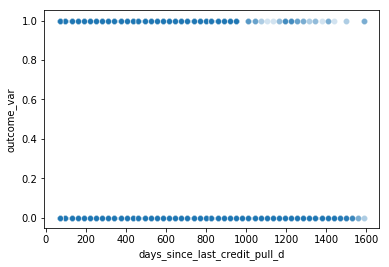

In [41]:
var_x_str = 'days_since_last_credit_pull_d'
var_y_str = 'outcome_var'
sns.scatterplot(x=var_x_str, y=var_y_str, data=lc_d_2015, alpha=0.2);
print(lc_d_2015[[var_x_str, var_y_str]].corr())

In [42]:
# More cleaning and feature engineering

convert_list = ['int_rate','revol_util']
for col in convert_list:
    new_list = []
    new_name = col + '_float'
    for i in lc_d_2015[col]:
        if col != 'revol_util':
            new_list.append(float(re.findall(r'\d+\.\d+', i)[0])/100)
        else:
            new_list.append(float(re.findall(r'\d+', i)[0])/100)
    lc_d_2015[new_name] = new_list

emp_length_int = []
for i in lc_d_2015['emp_length_2']:
    if i == 'none':
        emp_length_int.append(0)
    else:
        emp_length_int.append(int(re.findall(r'\d+', i)[0]))
lc_d_2015['emp_length_int'] = emp_length_int

earliest_cr_yrs = []
for i in lc_d_2015['earliest_cr_line']:
    earliest_cr_yrs.append(2019 - int(re.findall(r'\d+', i)[0]))
lc_d_2015['earliest_cr_yrs'] = earliest_cr_yrs

own_home = []
for i in lc_d_2015['home_ownership']:
    if i == 'OWN':
        own_home.append(1)
    else:
        own_home.append(0)
lc_d_2015['own_home'] = own_home

In [43]:
lc_d_2015.groupby(by=['loan_status']).mean()['int_rate_float']

loan_status
Charged Off    0.177753
Fully Paid     0.173248
Name: int_rate_float, dtype: float64

In [44]:
# Figure out the features I want in my model
model_cols = ['outcome_var', 'recoveries', 'total_rec_int', 'total_rec_prncp',
              #'grade',
              #'days_since_last_credit_pull_d',  <- this variable has forward looking bias
              'sub_grade',
              'loan_amnt', 'int_rate_float', 'home_ownership', 'annual_inc',
              'verification_status', 'issue_d', 'purpose', 'addr_state', 
              'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
              'revol_bal', 'revol_util_float', 'total_acc', 'collections_12_mths_ex_med',
              'acc_now_delinq', 'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths', 
              'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
              'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
              'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
              'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
              'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
              'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
              'total_bc_limit', 'total_il_high_credit_limit', 'mths_since_last_delinq_cat',
              'mths_since_last_record_cat', 'mths_since_last_major_derog_cat', 'mths_since_rcnt_il_cat',
              'mths_since_recent_bc_cat', 'mths_since_recent_bc_dlq_cat', 'mths_since_recent_inq_cat',
              'mths_since_recent_revol_delinq_cat', 'emp_length_int', 'earliest_cr_yrs']

model_data = lc_d_2015[model_cols].copy()

In [45]:
# Cluster Analysis

from sklearn.cluster import KMeans

cluster_cols = ['emp_length_int', 'annual_inc', 'verification_status', 'purpose', 'home_ownership']

# Add interactions
cluster_str = cluster_cols[0]
for i in cluster_cols[1:]:
    cluster_str = cluster_str + ' + ' + i

cluster_patsy = dmatrix(cluster_str, model_data)

cluster_model = KMeans(n_clusters=5)
cluster_model.fit(cluster_patsy)
my_clusters = ['group_' + str(i) for i in cluster_model.labels_]

model_data['my_clusters'] = my_clusters

In [48]:
# Use Patsy to create my X Matrix 
x_cols = ['my_clusters', 'loan_amnt', 'own_home', 'annual_inc',
          'verification_status', 'issue_d', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
          'revol_bal', 'revol_util_float', 'total_acc', 'collections_12_mths_ex_med',
          'acc_now_delinq', 'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths', 
          'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
          'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
          'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
          'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
          'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
          'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
          'total_bc_limit', 'total_il_high_credit_limit', 'mths_since_last_delinq_cat',
          'mths_since_last_record_cat', 'mths_since_last_major_derog_cat',
          'mths_since_recent_bc_cat', 'mths_since_recent_bc_dlq_cat',
          'mths_since_recent_revol_delinq_cat', 'emp_length_int', 'earliest_cr_yrs']

# Add interactions
x_str = x_cols[0]
for i in x_cols[1:]:
    x_str = x_str + ' + ' + i
x_str = x_str + '+ loan_amnt*revol_util_float + revol_util_float*revol_bal'

x_patsy = dmatrix(x_str, model_data)
print(x_patsy.shape)

(32155, 88)


In [49]:
prob_A = rf_A.predict_proba(x_patsy)[:,1]
model_data['prob_A'] = prob_A

In [80]:
# Second patsy matrix that includes the new prob_A engineered feature (looks redundant but it is not)

x_cols = ['my_clusters',
          'prob_A',        # This is a new custom variable generated in another file
          #'sub_grade',
          'loan_amnt', 'int_rate_float', 'home_ownership', 'annual_inc',
          'verification_status', 'issue_d', 'purpose', 'addr_state', 
          'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
          'revol_bal', 'revol_util_float', 'total_acc', 'collections_12_mths_ex_med',
          'acc_now_delinq', 'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths', 
          'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
          'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
          'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
          'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
          'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
          'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
          'total_bc_limit', 'total_il_high_credit_limit', 'mths_since_last_delinq_cat',
          'mths_since_last_record_cat', 'mths_since_last_major_derog_cat', 'mths_since_rcnt_il_cat',
          'mths_since_recent_bc_cat', 'mths_since_recent_bc_dlq_cat', 'mths_since_recent_inq_cat',
          'mths_since_recent_revol_delinq_cat', 'emp_length_int', 'earliest_cr_yrs']

# Add interactions
x_str = x_cols[0]
for i in x_cols[1:]:
    x_str = x_str + ' + ' + i
x_str = x_str + '+ loan_amnt*int_rate_float*revol_util_float + revol_util_float*revol_bal'

x_patsy = dmatrix(x_str, model_data)
print(x_patsy.shape)

(32155, 158)


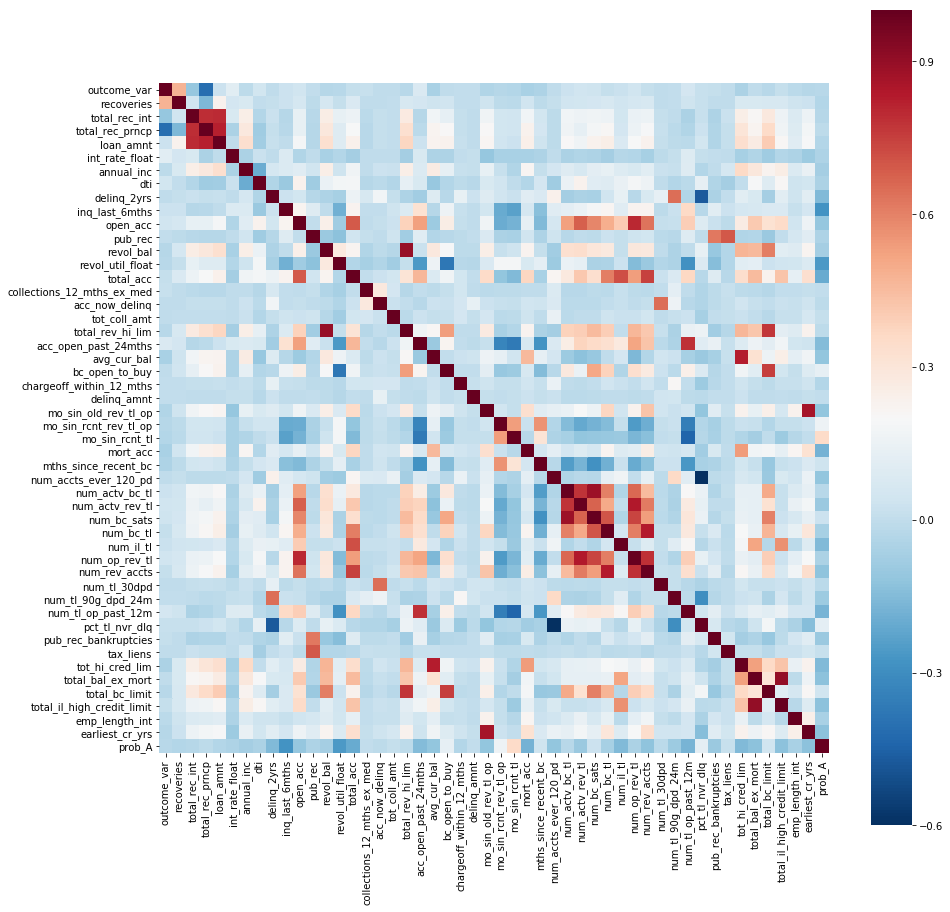

In [81]:
# Plot the correlation matrix
corrs = model_data.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrs, square=True, cmap="RdBu_r");
plt.savefig(fname='corr_matrix', dpi=150)

In [82]:
# Stratified train test split

x_raw = x_patsy
y_raw = np.array(model_data['outcome_var'])

y_int_rate = np.array(model_data['int_rate_float'])
y_loan_amnt = np.array(model_data['loan_amnt'])
y_int_rec = np.array(model_data['total_rec_int'])
y_prin_rec = np.array(model_data['total_rec_prncp'])
y_recoveries = np.array(model_data['recoveries'])

y_returns = np.array(model_data['outcome_var'])
y_returns = np.append(y_returns.reshape((-1,1)), y_int_rate.reshape((-1,1)), axis=1)
y_returns = np.append(y_returns, y_loan_amnt.reshape((-1,1)), axis=1)
y_returns = np.append(y_returns, y_int_rec.reshape((-1,1)), axis=1)
y_returns = np.append(y_returns, y_prin_rec.reshape((-1,1)), axis=1)
y_returns = np.append(y_returns, y_recoveries.reshape((-1,1)), axis=1)

sss1 = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
sss2 = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=0)

sss1.get_n_splits()
for train_index, test_index in sss1.split(x_raw, y_raw):
    x_mid, x_test = x_raw[train_index, :], x_raw[test_index, :]
    y_mid, y_test = y_raw[train_index], y_raw[test_index]

y_returns_test = y_returns[test_index, :]
    
sss2.get_n_splits()
for train_index, test_index in sss2.split(x_mid, y_mid):
    x_train, x_val = x_mid[train_index, :], x_mid[test_index, :]
    y_train, y_val = y_mid[train_index], y_mid[test_index]

In [83]:
# Upsample defaults (outcome_var=1)

# Separate majority and minority classes
x_train_0 = x_train[y_train==0,:]
x_train_1 = x_train[y_train==1,:]
 
# Upsample minority class
x_train_1_up = resample(x_train_1, replace=True, n_samples=x_train_0.shape[0], random_state=0)
 
# Combine majority class with upsampled minority class
x_train_up = np.append(x_train_0, x_train_1_up, axis=0)
y_train_up = np.append(np.zeros(x_train_0.shape[0]), np.ones(x_train_1_up.shape[0]))
 
print(x_train_0.shape)
print(x_train_1_up.shape)
print(x_train_up.shape)

(13871, 158)
(13871, 158)
(27742, 158)


In [84]:
# Normalize my variables
scaler = StandardScaler()
scaler.fit(x_train_up)
x_norm_train = scaler.transform(x_train)
x_norm_val = scaler.transform(x_val)
x_norm_test = scaler.transform(x_test)
x_mid_train = scaler.transform(x_mid)

# Change intercept back to 1
#x_norm_train[:,0] = 1
#x_norm_val[:,0] = 1
#x_norm_test[:,0] = 1

In [85]:
# Run CV with 5 folds (knn)

# ks = [501]
# param_grid = [{'n_neighbors': ks}]

# knn = KNeighborsClassifier()
# knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
# knn_grid.fit(x_norm_train, y_train)

In [86]:
# Run CV with 5 folds (logit)

penalty = ['l2']
C = np.logspace(0, 4, 10)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e+00, 2.78256e+00, 7.74264e+00, 2.15443e+01, 5.99484e+01,
       1.66810e+02, 4.64159e+02, 1.29155e+03, 3.59381e+03, 1.00000e+04]), 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [87]:
# Run CV with 5 folds (SVM)

# C = [1]
# gammas = [0.001, 0.1]
# param_grid = dict(C=C, gamma=gammas)

# svm1 = svm.SVC(kernel='rbf', probability=True)
# svm_grid = GridSearchCV(svm1, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
# svm_grid.fit(x_norm_train, y_train)

In [88]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(x_norm_train, y_train)

In [89]:
# Run CV with 5 folds (Random Forest)

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth':  [15],
    'max_features': ['sqrt'],
    'min_samples_leaf': [10, 15],
    'min_samples_split': [2, 5],
    'n_estimators': [500, 700]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  5.8min remaining:   18.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [15], 'max_features': ['sqrt'], 'min_samples_leaf': [10, 15], 'min_samples_split': [2, 5], 'n_estimators': [500, 700]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [90]:
# Train a neural network that doesn't crash your kernel

# n_cols = x_norm_val.shape[1]
# nn_model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(n_cols,100))

# nn_model.fit(x_norm_train, y_train)

In [91]:
# Bagging

# bagging_logit = BaggingClassifier(linear_model.LogisticRegression(solver='lbfgs', max_iter=10000, C=100000), 
#                                   n_estimators=500, max_samples=0.50, max_features=0.80, verbose=10)
# bagging_logit.fit(x_norm_train, y_train)

In [92]:
# Gradient Boosting

# params = {'n_estimators': 500,
#           'max_leaf_nodes': 5, 
#           'max_depth': None, 
#           'min_samples_split': 5,
#           'learning_rate': 0.1, 
#           'subsample': 0.20}

# gboost = GradientBoostingClassifier(**params)
# gboost.fit(x_norm_train, y_train)

# Grid search and CV

# Create the parameter grid based on the results of random search 
# param_grid = {
#     'max_depth': [15],
#     'min_samples_leaf': [10],
#     'min_samples_split': [5],
#     'n_estimators': [700],
#     'learning_rate': [0.15], 
#     'subsample': [0.50]
# }

# gboost = GradientBoostingClassifier(max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=700,
#                                     learning_rate=0.15, subsample=0.50, verbose=10)
# #gboost_grid = GridSearchCV(gboost, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
# gboost.fit(x_norm_train, y_train)

In [93]:
# # Train a neural network
# nn_model = Sequential()

# #get number of columns in training data
# n_cols = x_norm_val.shape[1]

# #add model layers
# nn_model.add(Dense(10, activation='relu', input_dim=n_cols))
# nn_model.add(Dense(10, activation='relu'))
# nn_model.add(Dense(1))

# # compiling the model
# nn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

# # training the model
# from keras.callbacks import EarlyStopping
# early_stopping_monitor = EarlyStopping(patience=3)
# nn_model.fit(x_norm_train, y_train, epochs=30, callbacks=[early_stopping_monitor])

In [94]:
#print('Best ROC_AUC for knn: %0.4f' % knn_grid.best_score_)
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
#print('Best ROC_AUC for svm: %0.4f' % svm_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % rf_grid.best_score_)

Best ROC_AUC for logit: 0.5918
Best ROC_AUC for rf: 0.6029


In [95]:
#print('Best Params for knn: ', knn_grid.best_params_)
print('Best Params for logit: ', logistic_grid.best_params_)
#print('Best Params for svm: ', svm_grid.best_params_)
print('Best Params for rf: ', rf_grid.best_params_)

Best Params for logit:  {'C': 1.0, 'penalty': 'l2'}
Best Params for rf:  {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 700}


In [96]:
# Fit sub_grade Classifier

x_patsy_sg_train = x_norm_train[:,5:14]
x_patsy_sg_val = x_norm_val[:,5:14]
x_patsy_sg_test = x_norm_test[:,5:14]

logistic_sub_grade = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_sub_grade.fit(x_patsy_sg_train, y_train)
logistic_sub_grade.coef_

array([[ 0.02944592,  0.14001601,  0.05660259,  0.09842849, -0.01164236,
         0.04291052, -0.02445526, -0.0211125 , -0.03341205]])

In [97]:
# Fit Dummy Classifier
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(x_norm_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

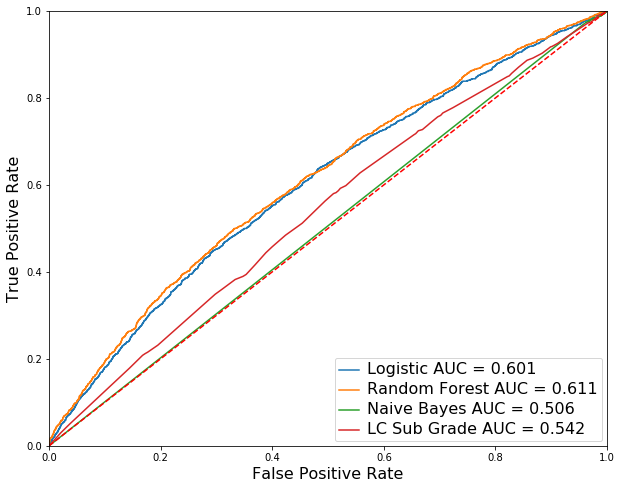

In [167]:
# ROC for all the models

# model_list = [knn_grid.best_estimator_, 
#               logistic_grid.best_estimator_, 
#               svm_grid.best_estimator_, 
#               gnb_best, 
#               rf_grid.best_estimator_,
#               'ensemble',
#               logistic_sub_grade,
#               dummy]
# model_name = ['knn', 'logit', 'svm', 'n_bayes', 'random_forest', 'ensemble', 'sg_only', 'dummy']

# ROC for just the FASTEST models

# model_list = [logistic_grid.best_estimator_, 
#               gnb_best, 
#               rf_grid.best_estimator_,
#               'ensemble',
#               logistic_sub_grade,
#               dummy]
# model_name = ['logit', 'n_bayes', 'random_forest', 'ensemble', 'sg_only', 'dummy']

# ROC for testing

#model_list = [gboost,
#              bagging_logit,
#              logistic_grid.best_estimator_,
#              rf_grid.best_estimator_,
#              logistic_sub_grade,
#              dummy]
#model_name = ['gboost', 'bagging', 'logit', 'rand_forest', 'sg_only', 'dummy']

model_list = [logistic_grid.best_estimator_,
              rf_grid.best_estimator_,
              gnb,
              logistic_sub_grade]
model_name = ['Logistic', 'Random Forest', 'Naive Bayes', 'LC Sub Grade']

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    if model == 'ensemble':
        w1 = 0.50
        w2 = 0.50
        y_pred = (w1*logistic_grid.best_estimator_.predict_proba(x_norm_val)[:,1] 
                  + w2*rf_grid.best_estimator_.predict_proba(x_norm_val)[:,1]
                  + (1-w1-w2)*gnb_best.predict_proba(x_norm_val)[:,1])
        
    elif model == logistic_sub_grade:
        y_pred = list(model.predict_proba(x_patsy_sg_val)[:,1])
    else:
        y_pred = list(model.predict_proba(x_norm_val)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.3f' % roc_auc))

plt.legend(loc = 'lower right')
#plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
ax.set_xlabel("False Positive Rate",fontsize=16)
ax.set_ylabel("True Positive Rate",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=16)
plt.savefig(fname='ROC_Curve', dpi=150)
plt.show()

In [99]:
# Examine the correlation of the model errors

#knn_error = y_train - knn_grid.predict_proba(x_norm_train)[:,1]
logit_error = y_train - logistic_grid.predict_proba(x_norm_train)[:,1]
#svm_error = y_train - svm_grid.predict_proba(x_norm_train)[:,1]
gnb_error = y_train - gnb_best.predict_proba(x_norm_train)[:,1]
rf_error = y_train - rf_grid.predict_proba(x_norm_train)[:,1]

error_df = pd.DataFrame()
#error_df['knn'] = knn_error
error_df['logit'] = logit_error
#error_df['svm'] = svm_error
error_df['gnb'] = gnb_error
error_df['rand_forest'] = rf_error

error_df.corr()

,logit,gnb,rand_forest
logit,1.000000,0.943930,0.990924
gnb,0.943930,1.000000,0.946757
rand_forest,0.990924,0.946757,1.000000


In [163]:
# Set cutoff by minimizing default rate within the loans chosen by my model

cutoff = 0.15
y_pred = logistic_grid.best_estimator_.predict_proba(x_norm_val)

y_class = []
for i in y_pred[:,1]:
    if i >= cutoff:
        y_class.append(1)
    else:
        y_class.append(0)
    
conf_mat = metrics.confusion_matrix(y_val, y_class)
print(conf_mat)
my_default_rate = conf_mat[1,0]/(conf_mat[0,0] + conf_mat[1,0])
total_default_rate = np.sum(conf_mat, axis=1)[1]/(np.sum(conf_mat, axis=1)[0] + np.sum(conf_mat, axis=1)[1])
print('Default Rate of Model Loans %.2f' % (my_default_rate*100), '%')
print('Default Rate of All Loans %.2f' % (total_default_rate*100), '%')
print((conf_mat[0,0] + conf_mat[1,0]))

[[ 195 4429]
 [  43 1764]]
Default Rate of Model Loans 18.07 %
Default Rate of All Loans 28.10 %
238


In [166]:
# Set cutoff by minimizing default rate within the loans chosen by my model

cutoff = 0.172
y_pred = rf_grid.best_estimator_.predict_proba(x_norm_val)

y_class = []
for i in y_pred[:,1]:
    if i >= cutoff:
        y_class.append(1)
    else:
        y_class.append(0)
    
conf_mat = metrics.confusion_matrix(y_val, y_class)
print(conf_mat)
my_default_rate = conf_mat[1,0]/(conf_mat[0,0] + conf_mat[1,0])
total_default_rate = np.sum(conf_mat, axis=1)[1]/(np.sum(conf_mat, axis=1)[0] + np.sum(conf_mat, axis=1)[1])
print('Default Rate of Model Loans %.2f' % (my_default_rate*100), '%')
print('Default Rate of All Loans %.2f' % (total_default_rate*100), '%') 
print((conf_mat[0,0] + conf_mat[1,0]))
print(np.sum(conf_mat))

[[  96 4528]
 [  15 1792]]
Default Rate of Model Loans 13.51 %
Default Rate of All Loans 28.10 %
111
6431


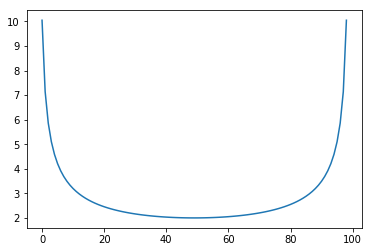

In [150]:
# Checking some things (debugging code, feel free to ignore)
len_test = 100
z_score_delta = []
for i in range(1,len_test):
    my_zeros = np.zeros((1,i))
    my_ones = np.ones((1,len_test-i))
    test = np.append(my_zeros, my_ones, axis=1)
    test_mu = np.mean(test)
    test_sigma = np.var(test)**0.5
    z_score = [(i-test_mu)/test_sigma for i in test]
    z_score_delta.append((np.max(z_score) - np.min(z_score)))
plt.plot(z_score_delta);

In [151]:
# Use test set to measure model performance

# param_grid = {
#     'max_depth':  [15],
#     'max_features': ['sqrt'],
#     'min_samples_leaf': [10, 15],
#     'min_samples_split': [2, 5],
#     'n_estimators': [500, 700]
# }

rf_params = rf_grid.best_params_

rf_final = RandomForestClassifier(max_depth = rf_params['max_depth'],
                                  max_features = rf_params['max_features'],
                                  min_samples_leaf = rf_params['min_samples_leaf'],
                                  min_samples_split = rf_params['min_samples_split'],
                                  n_estimators = rf_params['n_estimators'])
rf_final.fit(x_mid_train, y_mid)

y_pred = rf_final.predict_proba(x_norm_test)

y_class = []
for i in y_pred[:,1]:
    if i >= cutoff:
        y_class.append(1)
    else:
        y_class.append(0)
    
conf_mat = metrics.confusion_matrix(y_test, y_class)
print(conf_mat)
my_default_rate = conf_mat[1,0]/(conf_mat[0,0] + conf_mat[1,0])
total_default_rate = np.sum(conf_mat, axis=1)[1]/(np.sum(conf_mat, axis=1)[0] + np.sum(conf_mat, axis=1)[1])
print('Test Set Default Rate of Model Loans %.2f' % (my_default_rate*100), '%')
print('Test Set Default Rate of All Loans %.2f' % (total_default_rate*100), '%')

[[ 105 4519]
 [   9 1798]]
Test Set Default Rate of Model Loans 7.89 %
Test Set Default Rate of All Loans 28.10 %


In [224]:
logistic_basic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000, C=1000)
logistic_basic.fit(x_mid, y_mid)

coef_df = pd.DataFrame()
coef_df['name'] = x_patsy.design_info.column_names
coef_df['coef'] = [i for i in logistic_basic.coef_[0]]
coef_df.sort_values(by='coef', ascending=False)

,name,coef
153,loan_amnt:int_rate_float,6.916376e-04
123,acc_open_past_24mths,1.009934e-04
154,loan_amnt:revol_util_float,3.383718e-05
143,num_tl_op_past_12m,2.313527e-05
127,delinq_amnt,2.291054e-05
10,issue_d[T.Dec-2015],1.208316e-05
62,addr_state[T.NY],9.074333e-06
2,my_clusters[T.group_2],8.011159e-06
119,collections_12_mths_ex_med,4.264416e-06
17,issue_d[T.Nov-2015],3.449489e-06


In [152]:
# Function to calculate IRR for backtesting

def calc_IRR(portfolio, debugging=False):
    irr = []
    loan_amnt = []
    for row in portfolio:
        loan_amnt.append(row[2])
        cash_flow = []
        if row[0] == 0:
            dur = np.ceil(row[3]/(row[1]*row[2]*3)*36)
            cash_flow.append(-row[2])
            for i in range(int(dur)):
                cash_flow.append(row[1]*row[2]/12)
            cash_flow.append(row[1]*row[2]/12 + row[4] + row[5])
        else:
            dur = 36
            cash_flow.append(-row[2])
            for i in range(int(dur)):
                cash_flow.append(row[3]/36)
            cash_flow.append(row[3]/36 + row[4] + row[5])
        irr.append(np.irr(cash_flow))
    
    weights = np.array(loan_amnt)*(1/sum(loan_amnt))
    mean_irr = np.sum(weights*irr)
    if debugging:
        return ((1 + mean_irr)**12 - 1), irr, weights
    else:
        return ((1 + mean_irr)**12 - 1)

In [153]:
# Backtest portfolio returns from your model vs. the entire sample (using the test set)

model_loans = y_returns_test[np.array(y_class) == 0]
y_default = y_returns_test[y_returns_test[:,0]==1]
y_success = y_returns_test[y_returns_test[:,0]==0]

model_IRR = []
default_IRR = []
success_IRR = []
lc_IRR = []

for i in range(1000):
    model_shuffled = shuffle(model_loans)
    model_IRR.append(calc_IRR(model_shuffled[0:100]))
    
    default_shuffled = shuffle(y_default)
    default_IRR.append(calc_IRR(default_shuffled[0:100]))
    
    success_shuffled = shuffle(y_success)
    success_IRR.append(calc_IRR(success_shuffled[0:100]))
    
    lc_shuffled = shuffle(y_returns_test)
    lc_IRR.append(calc_IRR(lc_shuffled[0:100]))

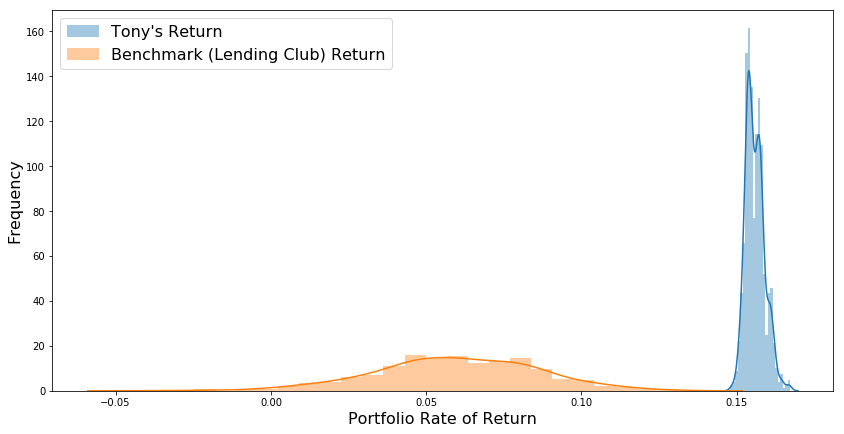

In [210]:
# Plot histogram of IRR
IRR_df = pd.DataFrame()
IRR_df['model_IRR'] = model_IRR
IRR_df['default_IRR'] = default_IRR
IRR_df['success_IRR'] = success_IRR
IRR_df['all_IRR'] = lc_IRR

fig, ax = plt.subplots(figsize=(14,7))
ax = sns.distplot(tuple(IRR_df['model_IRR']))
ax = sns.distplot(tuple(IRR_df['all_IRR']))
# ax = sns.distplot(tuple(IRR_df['default_IRR']))
# ax = sns.distplot(tuple(IRR_df['success_IRR']))

ax.set_xlabel("Portfolio Rate of Return",fontsize=16)
ax.set_ylabel("Frequency",fontsize=16)
plt.legend(labels=["Tony's Return", 'Benchmark (Lending Club) Return'], fontsize=16)
plt.savefig(fname='IRR_Hist', dpi=150)
plt.show()

In [205]:
print('Test Set IRR of Model Loans %.2f' % (np.mean(model_IRR)*100), '%')
print('Test Set IRR of All Loans %.2f' % (np.mean(lc_IRR)*100), '%')

Test Set IRR of Model Loans 15.59 %
Test Set IRR of All Loans 5.97 %


-0.031937771999999996
For every 1 unit change in my feature, the odds change by -3.14 %


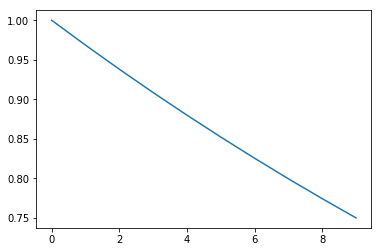

In [251]:
# Put your beta here
beta = (-2.661481e-03)*12

# Don't change this
my_list = [i*beta for i in range(0,10)]

# Calculating odds
odds = [np.exp(i) for i in my_list]

# Plotting odds
plt.plot(odds)

# Interpretation
print(beta)
print('For every 1 unit change in my feature, the odds change by %.2f' % ((odds[1]/odds[0]-1)*100), '%')